```
import Pyro4.util
try:
    [run your usual rfsoc experiment here]
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))
```

In [1]:
%matplotlib qt5
# %matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq
import Pyro4.util

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


# Load experiments

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_ring_down
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported

In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [5]:
data_path = 'S:\\QRAM\\qram_4QC\\'
# expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
expt_path = os.path.join(data_path, 'data', 'data_241007')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QC\data\data_241007


In [6]:
config_file = 'config_q3diamond_full688and638_v2_reset.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_zcu216.yml'
# config_file = 'config_zcu216_LLStdCandle.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_v2_reset.yml


# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [7]:
import yaml
print('Using config file', config_path)
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

Using config file s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_v2_reset.yml


In [8]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.62') # Spilker Fermium
# print(im)
print(im.keys())

dict_keys(['Pyro.NameServer', 'qick_qram_v2'])


In [9]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

QICK running on ZCU216, software version 0.2.296

Firmware configuration (built Mon Aug 21 11:09:34 2023):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MH

# RFSoC Calibration

In [43]:
qubit_i = 0

In [47]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=1.0, # [us]
    readout_length=1.5, # [us]
    trig_offset=0, # [clock ticks]
    gain=tof.cfg.device.readout.gain[qubit_i],
    # gain=30000, # [MUX units: -1 to 1]
    frequency=5000, # [MHz]
    reps=1000, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=10 # wait time between experiments [us]
print(tof.cfg)

import Pyro4.util
try:
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'readout': {'trig_offset': 170, 'lo_sideband': [1], 'T1': [32, 20, 22, 25], 'T2ramsey': [20, 27, 12, 5], 'chi': [0.45, 0.5, 0], 'kappa': [0.3, 0.2, 0.16, 0.18], 'frequency': [5342.94], 'gain': [0.01], 'readout_length': [10], 'relax_delay': 10}, 'qubit': {'f_ge': [3366], 'f_ge_robust': [3515.44], 'f_ef': [4114.49], 'pulses': {'pi_ge': {'sigma': [0.2], 'gain': [19981], 'half_gain': [19981], 'half_correction_phase': [0], 'half_gain_pi_sigma': [927], 'type': 'gauss'}, 'pi_ef': {'sigma': [0.02], 'gain': [1280], 'half_gain': [1261], 'half_gain_pi_sigma': [673], 'type': 'gauss'}, 'pi_EgGf': {'gain': [32000], 'sigma': [0.586], 'type': 'flat_top'}, 'pi_EgGf_Q': {'gain': [0, 0, 19500, 15088], 'sigma': [0, 0, 0.4524085976144402, 0.3229981046477775], 'phase': [0, 0, 18.0, 24.0], 'half_sigma': [0, 0, 0.212, 0.172], 'half_phase': [0, 0, 18.0, 21.0], 'type': 'flat_top'}, 'pi_f0g1': {'gain': [32000, 32000, 32000, 32000], 'sigma': [0.536, 0.585, 1.54, 1.04], 'idle': [3, 6, 12, 8], 'type': '

  0%|          | 0/1000 [00:00<?, ?it/s]

In [48]:
print('qubit_i', qubit_i)
print(np.average(tof.data['amps'][135:390]), '+/-', np.std(tof.data['amps'][135:390]))
tof.display(adc_trig_offset=145)

qubit_i 0
10.508172130454131 +/- 3.85256651076712


In [ ]:
tof.save_data()

# Resonator spectroscopy

## Single tone (resonator) spectroscopy

Measures the resonant frequency of the readout resonator when the qubit is in its ground state: sweep readout pulse frequency and look for the frequency with the maximum measured amplitude.

The resonator frequency should be stored in the parameter <code>cfg.device.readouti.frequency</code>.

Note that harmonics of the clock frequency (6144 MHz) will show up as "infinitely"  narrow peaks!


In [13]:
qubit_i = 0

In [65]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 2 # MHz
npts = 400
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]

    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span, # resonator frequency to be mixed up [MHz]
    # start=-807-span/2, # resonator frequency to be mixed up [MHz]
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span,
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.25*span,
    # start=-850,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number experiments stepping from start
    reps= 500, # Number averages per point
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qTest =qubit_i,
)

# rspec.cfg.device.readout.gain[qubit_i] = 0.6
# rspec.cfg.device.readout.frequency[qubit_i = 822.2138666666668
rspec.cfg.device.readout.readout_length = 10

# Wait time between experiments [us]
if not rspec.cfg.expt.pulse_e: rspec.cfg.device.readout.relax_delay = 10

print(rspec.cfg)
rspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 170, 'lo_sideband': [1], 'T1': [32, 20, 22, 25], 'T2ramsey': [20, 27, 12, 5], 'chi': [0.45, 0.5, 0], 'kappa': [0.3, 0.2, 0.16, 0.18], 'frequency': [5342.94], 'gain': [0.01], 'readout_length': 10, 'relax_delay': 10}, 'qubit': {'f_ge': [3366], 'f_ge_robust': [3515.44], 'f_ef': [4114.49], 'pulses': {'pi_ge': {'sigma': [0.2], 'gain': [19981], 'half_gain': [19981], 'half_correction_phase': [0], 'half_gain_pi_sigma': [927], 'type': 'gauss'}, 'pi_ef': {'sigma': [0.02], 'gain': [1280], 'half_gain': [1261], 'half_gain_pi_sigma': [673], 'type': 'gauss'}, 'pi_EgGf': {'gain': [32000], 'sigma': [0.586], 'type': 'flat_top'}, 'pi_EgGf_Q': {'gain': [0, 0, 19500, 15088], 'sigma': [0, 0, 0.4524085976144402, 0.3229981046477775], 'phase': [0, 0, 18.0, 24.0], 'half_sigma': [0, 0, 0.212, 0.172], 'half_phase': [0, 0, 18.0, 21.0], 'type': 'flat_top'}, 'pi_f0g1': {'gain': [32000, 32000, 32000, 32000], 'sigma': [0.536, 0.585, 1.54, 1.04], 'idle': [3, 6, 12, 8], 'type': 'fl

  0%|          | 0/400 [00:00<?, ?it/s]

Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout length
Using device readout

In [66]:
# # TESTING
# rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# # temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit1.h5')
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit0.h5')
# i_gain = np.argmin(np.abs(temp_data['gainpts']-30))
# temp_data['amps'] = temp_data['amps'][i_gain][80:]
# temp_data['xpts'] = temp_data['xpts'][80:]
# data = rspec.analyze(data=temp_data, fit=True)
# rspec.display(data=data, fit=True)

data = rspec.analyze(fit=True, findpeaks=False)
rspec.display(data=data, fit=True, findpeaks=False)

electrical delay phase correction (no mux support) (deg) -34.375373188765636
[5342.9375, 26714.6875, 26714.6875, 0, -0.01746302047373638, 0]
Attempted to init fitparam 5 to 0, which is out of bounds 0 to 1.0089470838976757. Instead init to 0.5044735419488379
[5.34298969e+03 6.98065193e+04 6.00279682e+04 2.77682078e-01
 2.57589959e-03 1.40210740e-28]

Freq with minimum transmission: 5342.995
Freq with maximum transmission: 5342.7699999999995
From fit:
	f0: 5342.989690602776
	Qi: 69806.51925368576 	 kappa_i/2pi: 0.07653998147630986
	Qe: 60027.96821861548 	 kappa_e/2pi: 0.08900833809907034
	Q0: 32274.502721061555
	kappa [MHz]: 0.1655483195753802
	phi [radians]: 0.2776820784881294
baseline 10.02238731214862


In [514]:
rspec.save_data()

Saving S:\QRAM\qram_4QR2_v2\data\data_241007\00000_resonator_spectroscopy_qubit0.h5


# Resonator Ring Down

In [ ]:
ringdown = meas.ResonatorRingDownExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_ringdown_qubit{qubit_i}",
    config_file=config_path,
)

TypeError: __init__() got an unexpected keyword argument 'pulse_e'

In [63]:
t_start =0.1   # [us]
t_stop = 10 + yaml_cfg.device.readout.readout_length[0] # [us]
npts = 20
reps = 5000 

ringdown.cfg.expt = dict(
    start_time = t_start,
    step_time = (t_stop-t_start)/npts,
    readout_length = [10], 
    expts = npts,
    reps = reps,
    pulse_e = False,
    pulse_f = False,    
    qTest = qubit_i
)

ringdown.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Readout time: 0.1 us, Offset time: 0.1 us
Using expt len_readout_adc
Readout time: 1.095 us, Offset time: 1.095 us
Using expt len_readout_adc
Readout time: 2.09 us, Offset time: 2.09 us
Using expt len_readout_adc
Readout time: 3.0849999999999995 us, Offset time: 3.0849999999999995 us
Using expt len_readout_adc
Readout time: 4.079999999999999 us, Offset time: 4.079999999999999 us
Using expt len_readout_adc
Readout time: 5.074999999999999 us, Offset time: 5.074999999999999 us
Using expt len_readout_adc
Readout time: 6.0699999999999985 us, Offset time: 6.0699999999999985 us
Using expt len_readout_adc
Readout time: 7.064999999999999 us, Offset time: 7.064999999999999 us
Using expt len_readout_adc
Readout time: 8.059999999999999 us, Offset time: 8.059999999999999 us
Using expt len_readout_adc
Readout time: 9.054999999999998 us, Offset time: 9.054999999999998 us
Using expt len_readout_adc
Readout time: 10 us, Offset time: 10.049999999999999 us
Using expt len_readout_adc
Readout time: 10 us, 

In [64]:
ringdown.display()

## Power sweep resonator spectroscopy

Repeat resonator spectroscopy at a range of powers to check that resonator frequency shifts at low powers. (Check qubit is alive.)

Use this experiment to determine the appropriate resonator gain, which should be stored in <code>cfg.device.readout.gain</code>


In [67]:
qubit_i = 0

In [505]:
rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"power_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 4000
npts_f = 400000

span_gain = 0.5
npts_gain = 2

rpowspec.cfg.expt = dict(
    start_f=6000-span_f*0.5, # sweep frequency [MHz]
    # start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.5, # sweep frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=rpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=0.1,
    # start_gain=0.2,
    step_gain=span_gain/npts_gain, # Gain step size
    # step_gain=0, # Gain step size
    expts_gain=npts_gain+1, # Number experiments stepping gain from start
    reps=400, # Number averages per point
    pulse_e=False, # add ge pi pulse before measurement
    pulse_f=False, # add ef pi pulse before measurement
    qTest=qubit_i,
)
rpowspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
rpowspec.cfg.device.readout.readout_length = 10

print(rpowspec.cfg)

rpowspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1], 'T1': [32, 20, 22, 25], 'T2ramsey': [20, 27, 12, 5], 'chi': [0.45, 0.5, 0], 'kappa': [0.3, 0.2, 0.16, 0.18], 'frequency': [5342.94], 'gain': [0.01], 'readout_length': 10, 'relax_delay': 10}, 'qubit': {'f_ge': [3366], 'f_ge_robust': [3515.44], 'f_ef': [4114.49], 'pulses': {'pi_ge': {'sigma': [0.2], 'gain': [19981], 'half_gain': [19981], 'half_correction_phase': [0], 'half_gain_pi_sigma': [927], 'type': 'gauss'}, 'pi_ef': {'sigma': [0.02], 'gain': [1280], 'half_gain': [1261], 'half_gain_pi_sigma': [673], 'type': 'gauss'}, 'pi_EgGf': {'gain': [32000], 'sigma': [0.586], 'type': 'flat_top'}, 'pi_EgGf_Q': {'gain': [0, 0, 19500, 15088], 'sigma': [0, 0, 0.4524085976144402, 0.3229981046477775], 'phase': [0, 0, 18.0, 24.0], 'half_sigma': [0, 0, 0.212, 0.172], 'half_phase': [0, 0, 18.0, 21.0], 'type': 'flat_top'}, 'pi_f0g1': {'gain': [32000, 32000, 32000, 32000], 'sigma': [0.536, 0.585, 1.54, 1.04], 'idle': [3, 6, 12, 8], 'type': 'fl

  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

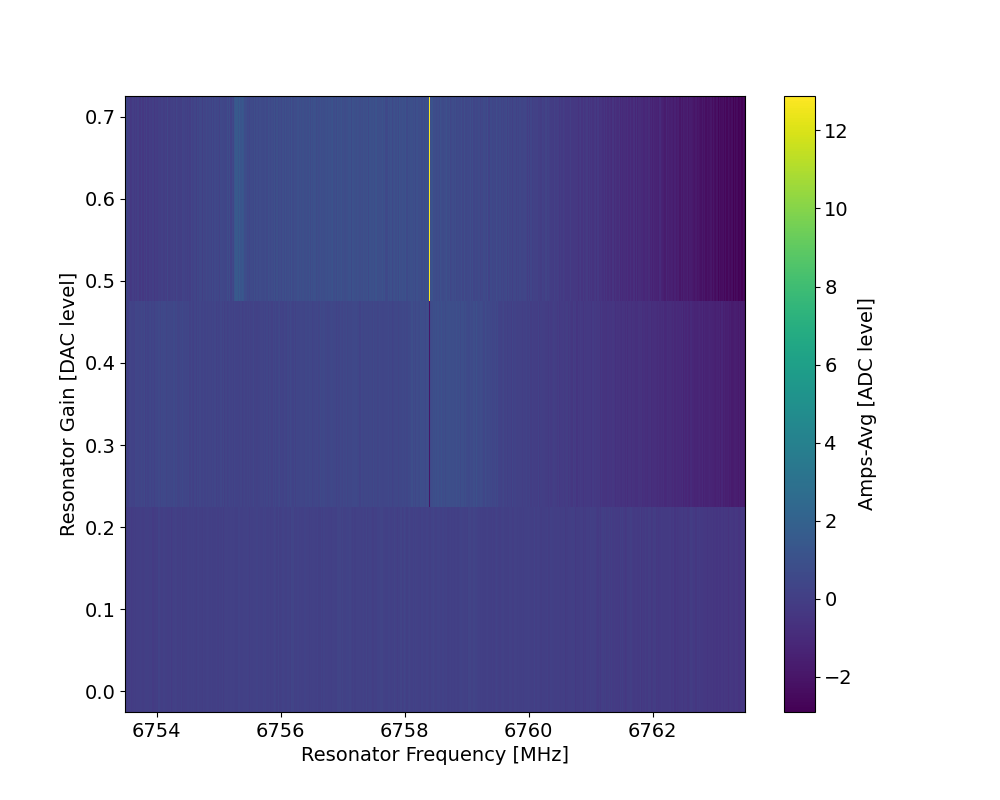

plotting at gain 0.1 index 0
plotting at gain 0.35 index 1
plotting at gain 0.6 index 2


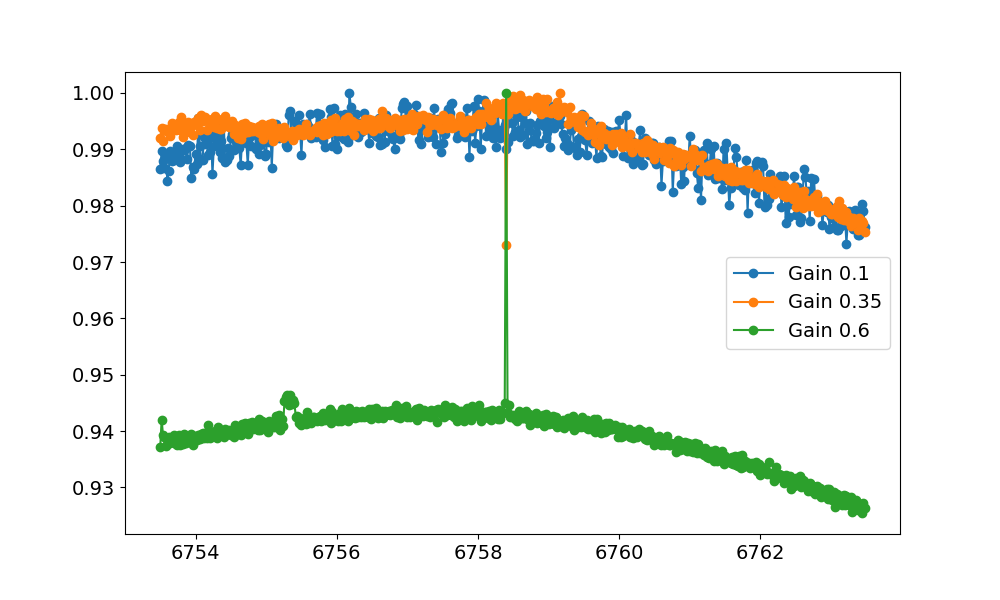

In [504]:
# # TESTING
# rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit1.h5')
# rpowspec.display(data=temp_data, fit=False)

# print('qubit', rpowspec.cfg.expt.qubit)
rpowspec.analyze(fit=False, lowgain=None, highgain=None)
rpowspec.display(fit=False, select=[0.1, 0.4, 0.6])

In [20]:
rpowspec.save_data()

Saving S:\QRAM\qram_4QR2_v2\data\data_241007\00000_power_sweep_resonator_spectroscopy_qubit0.h5


FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = 'S:\QRAM\qram_4QR2_v2\data\data_241007\00000_power_sweep_resonator_spectroscopy_qubit0.h5', errno = 2, error message = 'No such file or directory', flags = 15, o_flags = 502)

# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

Measures the qubit frequency f_ge by driving at resonator frequency and sweeping qubit frequency.

Qubit frequency should be stored in <code>cfg.qubiti.f_ge</code>.

In [287]:
qubit_i = 0

In [423]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 200
npts = 200

qspec.cfg.expt = dict(
    start= 3450- span/2, # [MHz]
    step=span/npts, # min step ~1 MHz
    expts=npts, # Number of experiments stepping from start
    reps=1000, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=10, # Qubit probe constant pulse length [us]
    gain=1000, # Qubit pulse gain
    # length=7.5, # Qubit probe constant pulse length [us]
    # gain=int(900), # Qubit pulse gain
    # gain=int(3869/150), # Qubit pulse gain
    # pulse_type='flat_top',
    pulse_type='const',
    qTest=qubit_i,
    qZZ=None, 
    checkEF=False,
)
print('start', qspec.cfg.expt.start, 'stop', qspec.cfg.expt.start+qspec.cfg.expt.step*qspec.cfg.expt.expts, 'npts', qspec.cfg.expt.expts)
qspec.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
# qspec.cfg.device.readout.relax_delay = 3 # Wait time between experiments [us]
# qspec.cfg.device.readout.frequency[qubit_i] = 6135.85
# qspec.cfg.device.readout.gain[qubit_i] = 0.010
# qspec.cfg.device.readout.readout_length[qubit_i] = 10

print(qspec.cfg)

qspec.go(analyze=False, display=False, progress=True, save=False)

start 3350.0 stop 3550.0 npts 200
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1], 'T1': [32, 20, 22], 'T2ramsey': [20, 27, 12], 'chi': [0.45, 0.5, 0], 'kappa': [0.3, 0.2, 0.16, 0.18], 'frequency': [5342.99], 'gain': [0.01], 'readout_length': [10], 'relax_delay': 100}, 'qubit': {'f_ge': [3515.450075466651], 'f_ge_robust': [3515.44], 'f_ef': [4114.49], 'pulses': {'pi_ge': {'sigma': [0.2], 'gain': [18993], 'half_gain': [18993], 'half_correction_phase': [0], 'half_gain_pi_sigma': [927], 'type': 'gauss'}, 'pi_ef': {'sigma': [0.02], 'gain': [1280], 'half_gain': [1261], 'half_gain_pi_sigma': [673], 'type': 'gauss'}, 'pi_EgGf': {'gain': [32000], 'sigma': [0.586], 'type': 'flat_top'}, 'pi_EgGf_Q': {'gain': [0, 0, 19500, 15088], 'sigma': [0, 0, 0.4524085976144402, 0.3229981046477775], 'phase': [0, 0, 18.0, 24.0], 'half_sigma': [0, 0, 0.212, 0.172], 'half_phase': [0, 0, 18.0, 21.0], 'type': 'flat_top'}, 'pi_f0g1': {'gain': [32000, 32000, 32000, 32000], 'sigma': [0.536, 0.585, 1.54

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3389.28418207887, HWHM 175.99956386091338
Found peak in I at [MHz] 3366.0, HWHM 19.7
Found peak in Q at [MHz] 3390.2074503332233, HWHM -6.781286670270026


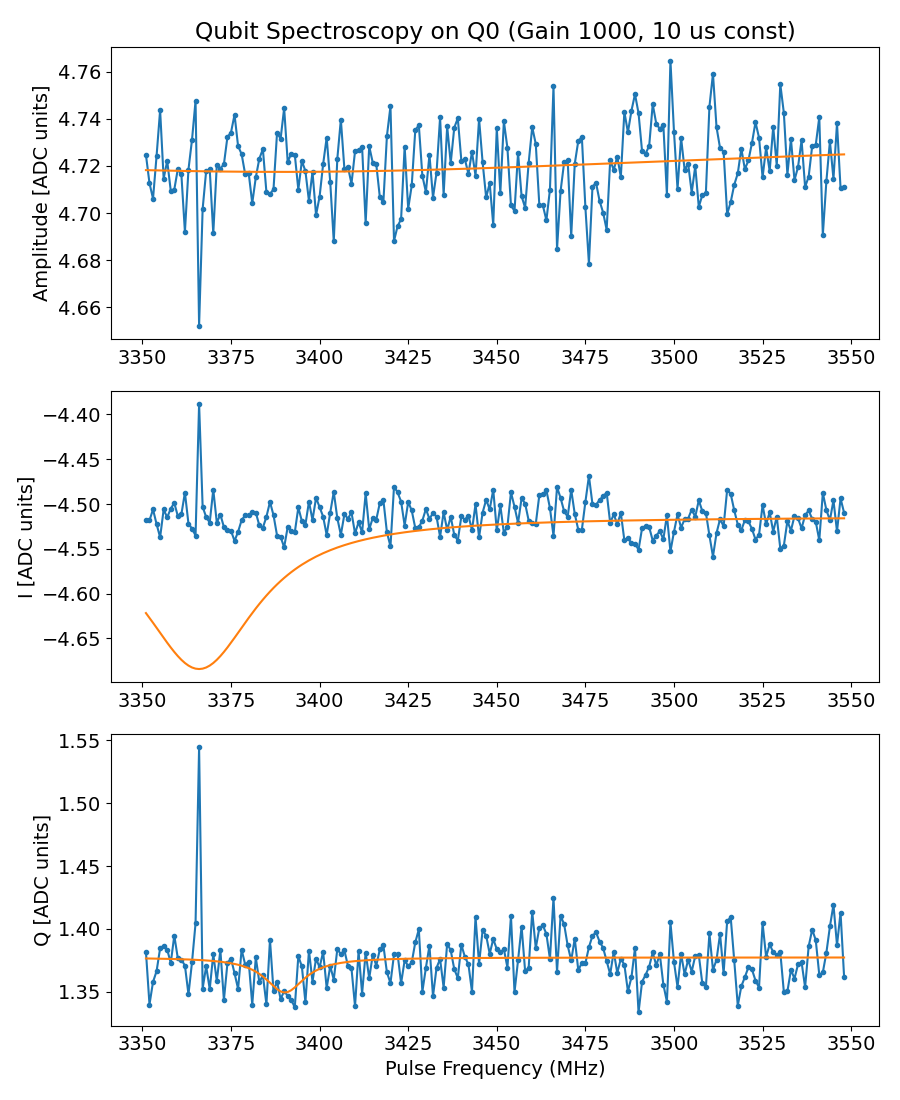

In [424]:
# TESTING
# qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_qubit_spectroscopy_qubit2.h5')
# qspec.data = temp_data
# qspec.cfg = AttrDict(attrs['config'])
# data = qspec.analyze(data=temp_data, fit=True)
# qspec.display(data=data, fit=True)

qspec.analyze(fit=True, signs=[1, -1, 1])
qspec.display(fit=True, signs=[1, -1, 1])

In [ ]:
qspec.data['fit_amps']

In [ ]:
qspec.save_data()

## Length Rabi

Measures Rabi oscillations by sweeping over the duration of the qubit drive pulse. This is a preliminary measurement to prove that we see Rabi oscillations. This measurement is followed up by the Amplitude Rabi experiment below.


In [ ]:
soc.cycles2us(1, gen_ch=0)

In [ ]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)

lengthrabi.cfg.expt = dict(
    start=soc.cycles2us(1), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=101,
    reps=1000,
    # gain=10000, # qubit gain [DAC units],
    # gain=lengthrabi.cfg.device.qubit.pulses.pi_ge.gain[qubit_i],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
    # qubits=[3,1],
)
# lengthrabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(lengthrabi.cfg)
# lengthrabi.im[lengthrabi.cfg.aliases.soc].reset()
import Pyro4.util
try:
    lengthrabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

lengthrabi.analyze(fit=True)
lengthrabi.display(fit=True)

In [ ]:
lengthrabi.save_data()

## Amplitude Rabi

Measures Rabi oscillations by sweeping over the amplitude of the qubit drive pulse, which is a Gaussian pulse with sigma set by <code>cfg.device.qubiti.pulses.pi_ge.sigma</code>. We measure the $\pi$ pulse amplitude which are used in subsequent experiments to control the qubit, which should be stored in <code>cfg.device.qubiti.pulses.pi_ge.gain</code>.

In [434]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)

    
amprabi.cfg.expt = dict(
    # start=0, # qubit gain [dac level]
    # step=int(span/npts), # [dac level]
    # expts=npts,
    start=0,
    step=int(350),
    expts=100,
    reps=100,
    rounds=10,
    sigma_test=0.200, # gaussian sigma for pulse length - overrides config [us]
    checkEF=False, 
    # qubits=[0, 1], # qZZ, qTest
    qTest=qubit_i,
    qZZ=None,
    # pulse_type='gauss',
    pulse_type='gauss',
    # n_pulses=10,
    # pulse_type='adiabatic',
    # mu=6, # dimensionless
    # beta=4, # dimensionless
    # sigma_test=0.100, # us
    # pulse_type='pulseiq',
    # Icontrols=I_values_MHz[0],
    # Qcontrols=Q_values_MHz[0],
    # times_us=times_us,
)

# amprabi.cfg.device.readout.relax_delay = 0 # Wait time between experiments [us]
# amprabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(amprabi.cfg)

import Pyro4.util
try:
    amprabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1], 'T1': [32, 20, 22, 25], 'T2ramsey': [20, 27, 12], 'chi': [0.45, 0.5, 0], 'kappa': [0.3, 0.2, 0.16, 0.18], 'frequency': [5342.94], 'gain': [0.01], 'readout_length': [10], 'relax_delay': [450]}, 'qubit': {'f_ge': [3366], 'f_ge_robust': [3515.44], 'f_ef': [4114.49], 'pulses': {'pi_ge': {'sigma': [0.2], 'gain': [19981], 'half_gain': [19981], 'half_correction_phase': [0], 'half_gain_pi_sigma': [927], 'type': 'gauss'}, 'pi_ef': {'sigma': [0.02], 'gain': [1280], 'half_gain': [1261], 'half_gain_pi_sigma': [673], 'type': 'gauss'}, 'pi_EgGf': {'gain': [32000], 'sigma': [0.586], 'type': 'flat_top'}, 'pi_EgGf_Q': {'gain': [0, 0, 19500, 15088], 'sigma': [0, 0, 0.4524085976144402, 0.3229981046477775], 'phase': [0, 0, 18.0, 24.0], 'half_sigma': [0, 0, 0.212, 0.172], 'half_phase': [0, 0, 18.0, 21.0], 'type': 'flat_top'}, 'pi_f0g1': {'gain': [32000, 32000, 32000, 32000], 'sigma': [0.536, 0.585, 1.54, 1.04], 'idle': [3, 6, 12, 8], 'type': '

  0%|          | 0/10 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 19709
	Pi/2 gain from amps data [dac units]: 9854
Pi gain from avgi data [dac units]: 19863
	Pi/2 gain from avgi data [dac units]: 9931
Pi gain from avgq data [dac units]: 19690
	Pi/2 gain from avgq data [dac units]: 9845


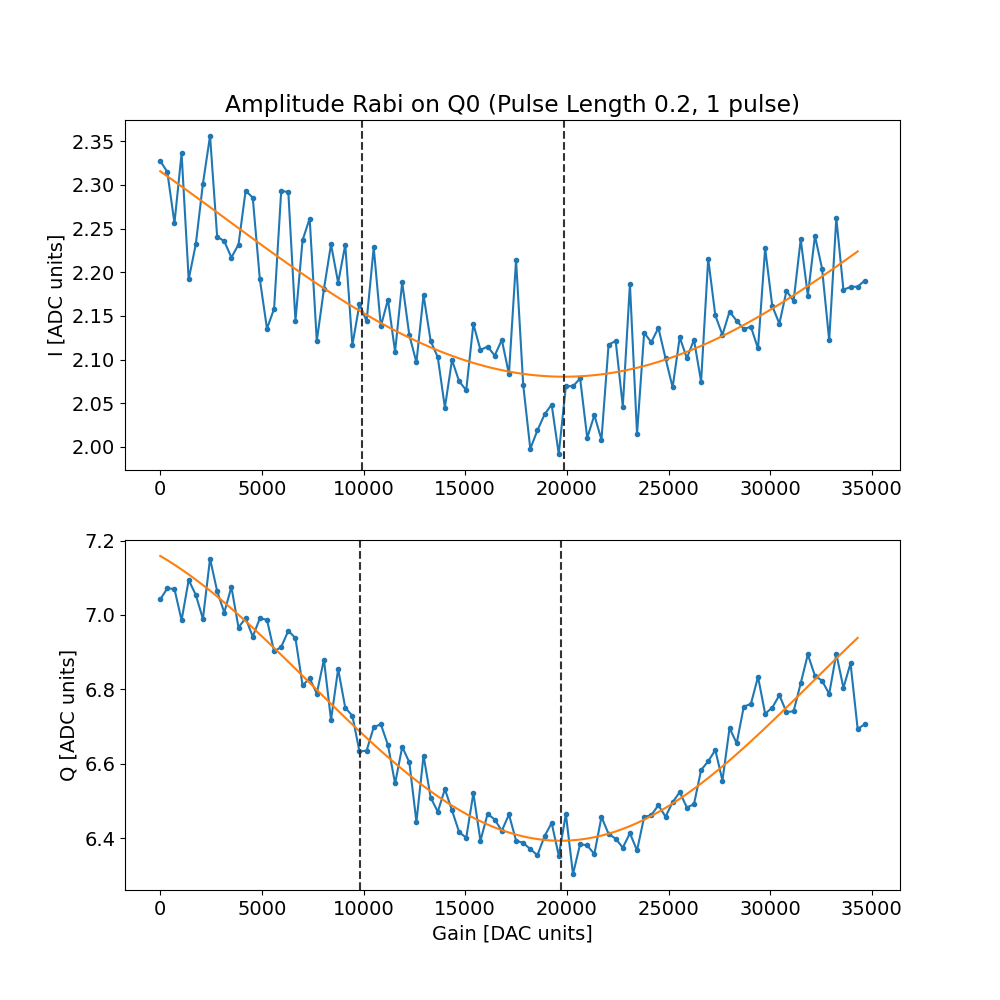

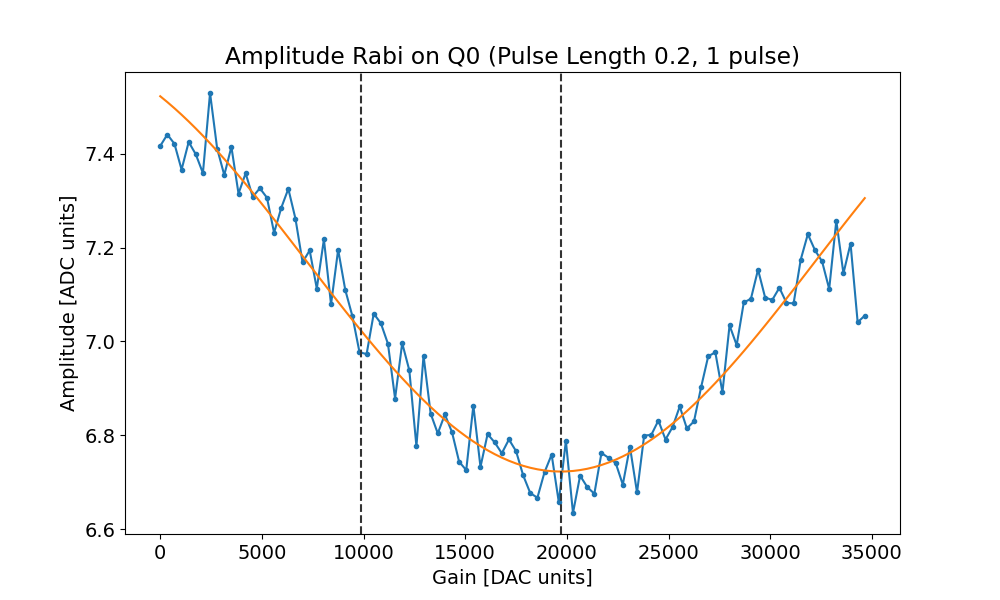

In [435]:
# # TESTING
# amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit2.h5')
# data = amprabi.analyze(data=temp_data, fit=True)
# amprabi.display(data=data, fit=True)

amprabi.analyze(fit=True)
amprabi.display(fit=True)

In [ ]:
amprabi.save_data()

## Amplitude rabi qubit frequency sweep (chevron)

In [ ]:
amprabichev = meas.AmplitudeRabiChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit_chevron{qubit_i}",
    config_file=config_path,
)

# span_gain = 10000
# npts_gain = 51
span_gain = 0
npts_gain = 1

span_f = 20
npts_f = 80

amprabichev.cfg.expt = dict(
    # start_f=amprabichev.cfg.device.qubit.f_ge[qubit_i]-span_f/2,
    # start_f=amprabichev.cfg.device.qubit.f_Q1_ZZ[0]-span_f/2,
    start_f=amprabichev.cfg.device.qubit.f_ef[qubit_i]-span_f/2,
    step_f=span_f/(npts_f-1),
    expts_f=npts_f,
    # start_gain=0, # qubit gain [dac level]
    start_gain=amprabichev.cfg.device.qubit.pulses.pi_ef.gain[qubit_i],
    step_gain=int(span_gain/npts_gain), # [dac level]
    expts_gain=npts_gain,
    reps=500,
    rounds=10,
    # sigma_test=0.2, # gaussian sigma for pulse length - overrides config [us]
    checkZZ=False,
    checkEF=True, 
    pulse_ge=True,
    qubits=[qubit_i],
    pulse_type='gauss',
    # pulse_type='adiabatic',
    # mu=6, # dimensionless
    # beta=4, # dimensionless
    # sigma_test=0.120*4, # us
)

# amprabichev.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

print(amprabichev.cfg)

amprabichev.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data_file = '/home/xilinx/jupyter_notebooks/_experiment/20211215_LL_StandardCandle1/data/00000_power_sweep_resonator_spectroscopy_qubit2.h5'
# with SlabFile(temp_data_file) as a:
#     temp_data = dict(
#         amps=np.asarray(a['amps']),
#         gainpts=np.asarray(a['gain']),
#         fpts=np.asarray(a['freq']),
#     )

# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

amprabichev.analyze()
amprabichev.display()

plt.figure()
data = amprabichev.data
plot_gain = amprabichev.cfg.device.qubit.pulses.pi_ef.gain[qubit_i]
gain_ind = np.argmin(np.abs(data['xpts']-plot_gain))
plt.title(f"Cut through gain {data['xpts'][gain_ind]}")
plt.plot(data['freqpts'], data['amps'][:, gain_ind], '.-')
plt.xlabel('Frequency [MHz]')


# check all the ZZ shifted
ZZs = np.reshape(amprabichev.cfg.device.qubit.ZZs, (4, 4))
good_ZZ_freq = amprabichev.cfg.device.qubit.f_ef[qubit_i]
plt.axvline(good_ZZ_freq, color='g', linestyle='--')
for i in range(4):
    if i == qubit_i: continue
    bad_ZZ_freq = amprabichev.cfg.device.qubit.f_ef[qubit_i]+ZZs[qubit_i, i]
    plt.axvline(bad_ZZ_freq, color='r', linestyle='--')



plt.show()

In [ ]:
amprabichev.save_data()

## Single Shot

Measures the single shot readout fidelity of the system. We acquire single shot (I, Q) readout values by first preparing the qubit in its ground (blue dots) a certain number of times and then preparing the qubit in its excited state (red dots) the same number of times. We then extract two parameters which are used to optimize the associated readout fidelity: the rotation angle of the IQ blobs and the threshold that classifies the two qubit states (ground and excited). The two output parameters should be stored in <code>cfg.device.readouti.phase</code> and <code>cfg.device.readouti.threshold</code>.

Note that this experiment already assumes that you have found your qubit frequency and $\pi$ pulse amplitude. Every time you reset the QICK firmware the single shot angle and threshold changes. So, this experiment is used to calibrate any experiment below that uses single shot data (such as the Active Reset experiment).

In [319]:
qubit_i = 0

In [389]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)

shot.cfg.expt = dict(
    reps=10000,
    check_e=True,

    # reps=100000000,
    # check_e=False,
    check_f=False,
    # qubit=1,
    qTest=qubit_i,

    # cool_qubits=[qubit_i],
    # cool_qubits=[0, 1, 2, 3],
    # cool_idle=[5],
)

# shot.cfg.device.readout.frequency[qubit_i] = shot.cfg.device.readout.frequency_ef[qubit_i]
# shot.cfg.device.readout.readout_length[qubit_i] = shot.cfg.device.readout.readout_length_ef[qubit_i]

# shot.cfg.device.readout.frequency_ef[qubit_i]=shot.cfg.device.readout.frequency_ef[qubit_i] - 1.3
# shot.cfg.device.readout.frequency=shot.cfg.device.readout.frequency_ef
# print(shot.cfg.device.readout.frequency_ef)
# shot.cfg.device.readout.frequency[qubit_i]=shot.cfg.device.readout.frequency[qubit_i] - 0.4
# shot.cfg.device.readout.gain[0]= 0.001
# shot.cfg.device.readout.gain[1]= 0.001
# shot.cfg.device.readout.gain[2]= 0.001
# shot.cfg.device.readout.gain[3]= 0.001



# shot.cfg.device.readout.gain[qubit_i] = 0.05
shot.cfg.device.readout.readout_length[qubit_i] = 10
# shot.cfg.device.readout.relax_delay = 500000  # Wait time between experiments [us]

# set the gains 

print('qubit', shot.cfg.expt.qTest)
print('readout params', shot.cfg.device.readout)

shot.go(analyze=False, display=False, progress=True, save=False)

qubit 0
readout params {'trig_offset': 150, 'lo_sideband': [1], 'T1': [32, 20, 22], 'T2ramsey': [20, 27, 12], 'chi': [0.45, 0.5], 'kappa': [0.3, 0.2], 'frequency': [5593.37], 'gain': [0.005], 'readout_length': [10], 'relax_delay': [450]}


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

qubit 0
g unrotated averages:
I -0.09313313802083333 +/- 1.2890657753591317 	 Q 3.1646592447916664 +/- 1.2838858664571644 	 Amp 3.4454600450086907 +/- 1.209380207619747
Rotated (theta=-0.12049737656945057):
I 0.28795317760435457 +/- 1.2890003585823435 	 Q 3.152907370118971 +/- 1.2839515438151443 	 Amp 3.1660293613677957 +/- 1.209380207619747
e unrotated averages:
I 1.41815712890625 +/- 1.5473337021730396 	 Q 3.3476522786458327 +/- 1.3535606339519504 	 Amp 3.965819275255104 +/- 1.310187342585125
Rotated (theta=-0.12049737656945057):
I 1.8102818941920984 +/- 1.5462330176385166 	 Q 3.1529073701189714 +/- 1.3548178589129303 	 Amp 3.6356492433938485 +/- 1.310187342585125


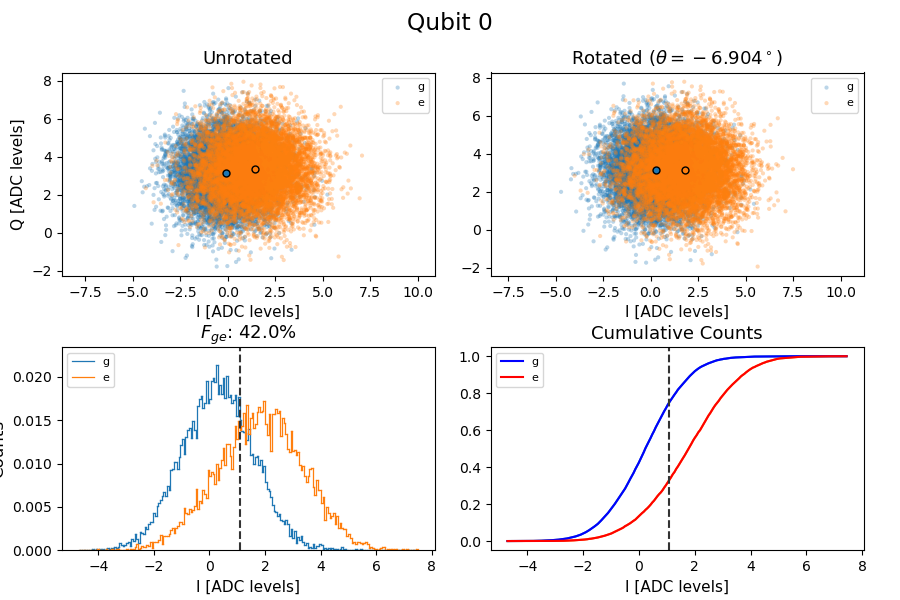

ge fidelity (%): 42.027513751375146
rotation angle (deg): -6.903991119828092
threshold ge: 1.0897167154322611


In [390]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

print('qubit', qubit_i)
shot.analyze(verbose=False)
shot.display(verbose=True, plot_f=True)

In [ ]:
# Checking for drift vs. shot number

data = shot.data
i = data['Ie']
q = data['Qe']
amps = np.abs(i+1j*q)
phases = np.angle(i+1j*q)

# plt.plot(amps, '.', label='amps')
# plt.ylabel('Amps [ADC units]')
# plt.xlabel('Shot number')
# plt.legend()
# plt.show()

plt.plot(phases, '.', label='phases')
plt.axhline(0, color='r')
plt.axhline(1.5, color='r')
plt.ylabel('Phases [radians]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

plt.plot(i, '.', label='i')
plt.ylabel('I [ADC units]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

plt.plot(q, '.', label='Q')
plt.ylabel('Q [ADC units]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

In [ ]:
shot.save_data()

Single shot drift

In [ ]:
import time

Igs = []
Qgs = []
Ies = []
Qes = []
angles = []

drift_meas_time = 2*60

start_time = time.time()
elapsed_time = 0
meas_times = []
for i in tqdm(range(20)):
# for i in tqdm(range(3)):
    shot = meas.HistogramExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"single_shot_qubit{qubit_i}",
        config_file=config_path,
    )

    shot.cfg.expt = dict(
        reps=20000,
        check_f=False,
        qubit=qubit_i,
    )

    # shot.cfg.device.readout.frequency=-82.015-0.54
    shot.cfg.device.readout.gain=0.75
    # shot.cfg.device.readout.readout_length = 10 # [us]
    # shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
    # print(shot.cfg)

    shot.go(analyze=False, display=False, progress=False, save=False)
    elapsed_time = time.time() - start_time

    shot.analyze(verbose=False)

    Ig = np.average(shot.data['Ig'])
    Qg = np.average(shot.data['Qg'])
    Ie = np.average(shot.data['Ie'])
    Qe = np.average(shot.data['Qe'])
    angle = shot.data['angle']
    # print('Ig', Ig, 'Qg', Qg, 'Ie', Ie, 'Qe', Qe, 'angle', angle)

    Igs.append(Ig)
    Qgs.append(Qg)
    Ies.append(Ie)
    Qes.append(Qe)
    angles.append(angle)

    meas_times.append(elapsed_time)
    if elapsed_time > drift_meas_time: break
    time.sleep(30)

    

In [ ]:
Igs = np.array(Igs)
Qgs = np.array(Qgs)
Ies = np.array(Ies)
Qes = np.array(Qes)
phase_gs = arctan(Igs/Qgs)
phase_es = arctan(Ies/Qes)
amps_gs = np.sqrt(Igs**2 + Qgs**2)
amps_es = np.sqrt(Ies**2 + Qes**2)

plt.plot(meas_times, Igs, label='Ig')
plt.plot(meas_times, Ies, label='Ie')
plt.ylabel('I [ADC units]')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()

plt.plot(meas_times, Qgs, label='Qg')
plt.plot(meas_times, Qes, label='Qe')
plt.ylabel('Q [ADC units]')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()

plt.plot(Qgs, Igs, label='Ig(Qg)')
plt.plot(Qes, Ies, label='Ie(Qe)')
plt.ylabel('I [ADC units]')
plt.xlabel('Q [ADC units]')
plt.legend()
plt.show()

plt.plot(meas_times, amps_gs, label='amps g')
plt.plot(meas_times, amps_es, label='amps e')
plt.ylabel('Amps [ADC units]')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()

plt.plot(meas_times, phase_gs, label='phases g')
plt.plot(meas_times, phase_es, label='phases e')
plt.ylabel('Phase (rad)')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()


### Single shot/readout optimization

In [347]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 2.0 # MHz
npts_f = 10

span_gain = 0.2
# npts_gain = 2
npts_gain = 10

span_len = 15 # us
# npts_len  2
npts_len = 10

shotopt.cfg.expt = dict(
    reps=1000,
    qTest=qubit_i,

    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.5*span_f,
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i] - 0.5*span_gain),
    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.01,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain,

    start_len=3.0,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1], 'T1': [32, 20], 'T2ramsey': [20, 27], 'chi': [0.45, 0.5], 'kappa': [0.3, 0.2], 'frequency': [6384.86], 'gain': [0.007], 'readout_length': [10], 'relax_delay': [450]}, 'qubit': {'f_ge': [4293.1229878861905], 'f_ge_robust': [4114.49], 'f_ef': [4114.49], 'pulses': {'pi_ge': {'sigma': [0.1], 'gain': [22847], 'half_gain': [22847], 'half_correction_phase': [0], 'half_gain_pi_sigma': [927], 'type': 'gauss'}, 'pi_ef': {'sigma': [0.02], 'gain': [1280], 'half_gain': [1261], 'half_gain_pi_sigma': [673], 'type': 'gauss'}, 'pi_EgGf': {'gain': [32000], 'sigma': [0.586], 'type': 'flat_top'}, 'pi_EgGf_Q': {'gain': [0, 0, 19500, 15088], 'sigma': [0, 0, 0.4524085976144402, 0.3229981046477775], 'phase': [0, 0, 18.0, 24.0], 'half_sigma': [0, 0, 0.212, 0.172], 'half_phase': [0, 0, 18.0, 21.0], 'type': 'flat_top'}, 'pi_f0g1': {'gain': [32000, 32000, 32000, 32000], 'sigma': [0.536, 0.585, 1.54, 1.04], 'idle': [3, 6, 12, 8], 'type': 'flat_top'}, 

  0%|          | 0/10 [00:00<?, ?it/s]

freq: 6383.86, gain: 0.01, len: 3.0
	fid ge [%]: 5.6000000000000005
freq: 6383.86, gain: 0.01, len: 4.5
	fid ge [%]: 6.7
freq: 6383.86, gain: 0.01, len: 6.0
	fid ge [%]: 6.503251625812906
freq: 6383.86, gain: 0.01, len: 7.5
	fid ge [%]: 6.1
freq: 6383.86, gain: 0.01, len: 9.0
	fid ge [%]: 5.2
freq: 6383.86, gain: 0.01, len: 10.5
	fid ge [%]: 5.6000000000000005
freq: 6383.86, gain: 0.01, len: 12.0
	fid ge [%]: 3.9019509754877437
freq: 6383.86, gain: 0.01, len: 13.5
	fid ge [%]: 6.6000000000000005
freq: 6383.86, gain: 0.01, len: 15.0
	fid ge [%]: 6.2
freq: 6383.86, gain: 0.01, len: 16.5
	fid ge [%]: 5.8999999999999995
freq: 6383.86, gain: 0.03, len: 3.0
	fid ge [%]: 11.3
freq: 6383.86, gain: 0.03, len: 4.5
	fid ge [%]: 9.3
freq: 6383.86, gain: 0.03, len: 6.0
	fid ge [%]: 7.8
freq: 6383.86, gain: 0.03, len: 7.5
	fid ge [%]: 7.103551775887944
freq: 6383.86, gain: 0.03, len: 9.0
	fid ge [%]: 13.606803401700851
freq: 6383.86, gain: 0.03, len: 10.5
	fid ge [%]: 11.5
freq: 6383.86, gain: 0.03,

(3, 3, 1)
[6383.86 6384.06 6384.26 6384.46 6384.66 6384.86 6385.06 6385.26 6385.46
 6385.66]
[0.01 0.03 0.05 0.07 0.09 0.11 0.13 0.15 0.17 0.19]
[ 3.   4.5  6.   7.5  9.  10.5 12.  13.5 15.  16.5]
Max fidelity 49.42471235617809 %
Set params: 
 angle (deg) -77.17820476056042 
 threshold -1.4220154535888927 
 freq [Mhz] 6384.46 
 gain [dac units] 0.06999999999999999 
 readout length [us] 4.5
[[[0.056      0.067      0.06503252 0.061      0.052      0.056
   0.03901951 0.066      0.062      0.059     ]
  [0.113      0.093      0.078      0.07103552 0.13606803 0.115
   0.122      0.085      0.10505253 0.082     ]
  [0.095      0.13206603 0.16208104 0.143      0.152      0.155
   0.154      0.148      0.18009005 0.154     ]
  [0.163      0.17008504 0.164      0.139      0.164      0.175
   0.23011506 0.211      0.20510255 0.198     ]
  [0.12206103 0.18909455 0.165      0.122      0.16208104 0.16
   0.171      0.128      0.148      0.129     ]
  [0.15       0.122      0.128      0.10205103 0

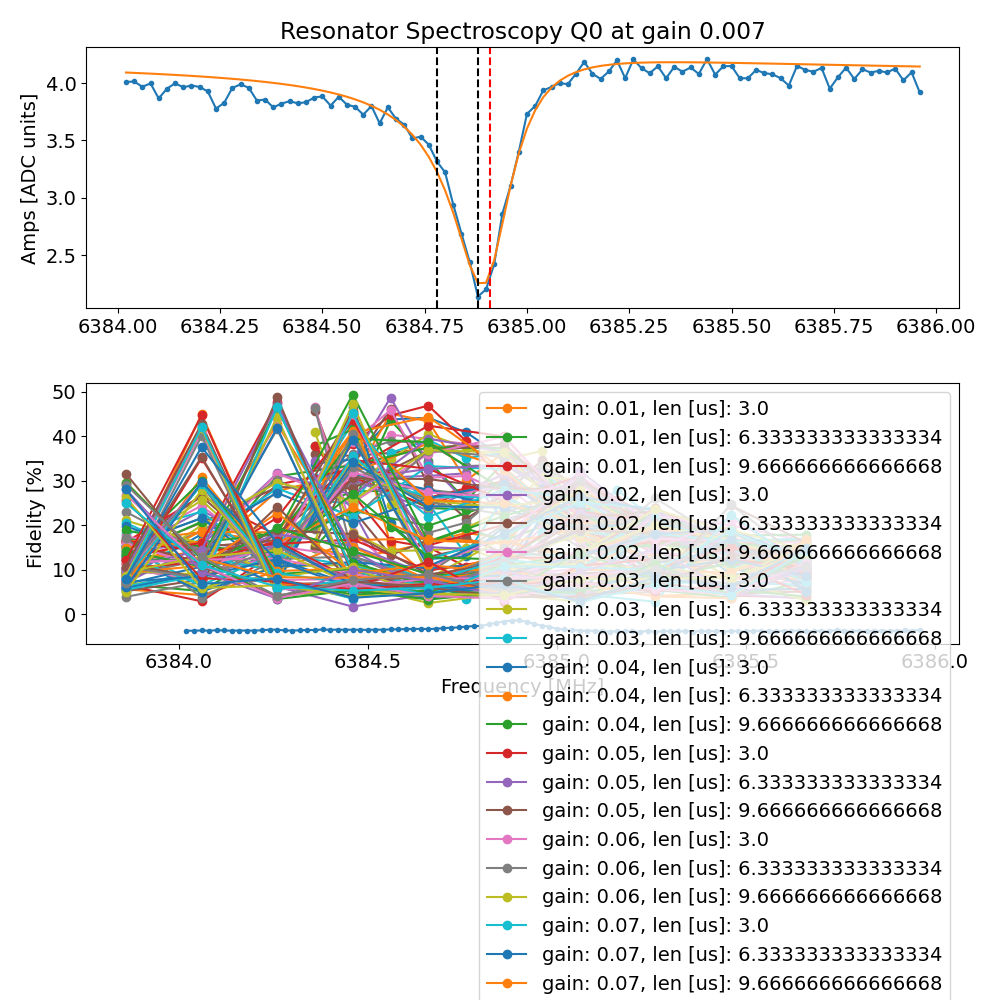

In [348]:
shotopt.analyze()
print(shotopt.data['fid'])
shotopt.display()

In [ ]:
shotopt.save_data()

### Single shot multi readout

In [13]:
qubit_i = 2

In [67]:
shot = meas.MultiReadoutExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"multi_readout_qubit{qubit_i}",
    config_file=config_path,
)

shot.cfg.expt = dict(
    reps=10000,
    check_e=True,
    check_f=False,
    qTest=qubit_i,

    readout_cool=False,
    n_init_readout=0, # number of readout blocks prior to final readout
    # n_trig=1, # extend readout by triggering this many times in a row
    # init_read_wait_us=10, # wait between readout blocks

    use_gf_readout=False,
    avg_trigs=True, # whether to combine data from trigger stacks into 1 averaged histogram
    # full_mux_expt=False,
    full_mux_expt=True,
    full_mux_ch=4,
    # mask=[0, 1, 2, 3],
    mask=[2],
    lengths=[4]*4, #[3, 3, 3, 3],
    
)

if shot.cfg.expt.full_mux_expt: shot.cfg.device.readout.readout_length = shot.cfg.expt.lengths

# shot.cfg.hw.soc.dacs.readout.mixer_freq[qubit_i] = 0.0
# shot.cfg.device.readout.frequency[qubit_i] = 0.0
# shot.cfg.device.readout.gain[qubit_i] = 0.5
shot.cfg.device.readout.gain = [0.1, 0.1, 1.0, 0.1]
# shot.cfg.device.readout.relax_delay = 10
print('qubit', shot.cfg.expt.qTest)

try:
    shot.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

qubit 2


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
shot.save_data()

In [68]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

print('qubit', qubit_i)
ps_adjust = [0]*4
ps_adjust[qubit_i] = -1.0
shot.analyze(fit=False, check_readouts=[0], post_select=False, ps_adjust=ps_adjust, verbose=False)
shot.display(fit=False, post_select=False, verbose=True, export=True)

qubit 2
dict_keys(['Ig_baseline', 'Qg_baseline', 'Ie_baseline', 'Qe_baseline', 'Ig', 'Qg', 'Ie', 'Qe', 'iqshots', 'ge_avgs'])
g play_pulses [0] unrotated averages:
I -0.7778764849471113 +/- 228.1550080181294 	 Q -0.05510642799023644 +/- 225.88078766029108 	 Amp 0.7798259704828484
Rotated (theta=1.1921044438270516):
I -0.23638301329787045 +/- 226.62007943935922 	 Q -0.7431363369286526 +/- 227.42070598932878 	 Amp 0.7798259704828489
e play_pulses [0] unrotated averages:
I -0.1960969080553306 +/- 409.1151947966712 	 Q -1.5172436126932458 +/- 409.7120170487578 	 Amp 1.529863450641041
Rotated (theta=1.1921044438270516):
I 1.3372473826273061 +/- 408.6977518512477 	 Q -0.7431363369286521 +/- 410.1284276411668 	 Amp 1.529863450641042
g_0 play_pulses [0] unrotated averages:
I 1.8877681041497147 +/- 228.6082317157729 	 Q -1.4513017900732301 +/- 223.85474174448657 	 Amp 2.38116469420214
Rotated (theta=1.1921044438270516):
I 2.046393645377484 +/- 223.85499938113688 	 Q 1.2174639005216639 +/- 228.6

In [ ]:
gain_vec = np.array([0.20])
readout_vec = np.array([15])
wait_vec = np.array([10])
n_trig = np.array([1, 2, 3, 4, 5, 6])

for t in n_trig:
    for w in wait_vec:
        for r in readout_vec:
            for g in gain_vec:
                print('gain', g, 'readout length', r)
                
                shot = meas.MultiReadoutExperiment(
                    soccfg=soc,
                    path=expt_path,
                    prefix=f"multi_readout_qubit{qubit_i}",
                    config_file=config_path,
                )

                shot.cfg.expt = dict(
                    reps=20000,
                    check_e=True,
                    check_f=False,
                    qTest=qubit_i,

                    readout_cool=True,
                    n_init_readout=1, # number of readout blocks prior to final readout
                    n_trig=t, # extend readout by triggering this many times in a row
                    # n_trig=1, # extend readout by triggering this many times in a row
                    # init_read_wait_us=10, # wait between readout blocks
                    init_read_wait_us=w, # wait between readout blocks

                    use_gf_readout=False,
                    avg_trigs=True, # whether to combine data from trigger stacks into 1 averaged histogram
                )
                # shot.cfg.device.readout.frequency[qubit_i] = shot.cfg.device.readout.frequency_ef[qubit_i]
                # shot.cfg.device.readout.readout_length[qubit_i] = shot.cfg.device.readout.readout_length_ef[qubit_i]
                shot.cfg.device.readout.readout_length[0] = r
                shot.cfg.device.readout.readout_length[1] = r
                shot.cfg.device.readout.readout_length[2] = r
                shot.cfg.device.readout.readout_length[3] = r
                
                # shot.cfg.device.readout.gain[qubit_i] = 0.5*shot.cfg.device.readout.gain[qubit_i]
                # shot.cfg.device.readout.readout_length[qubit_i] = 20
                shot.cfg.device.readout.gain[qubit_i] = g
                print('qubit', shot.cfg.expt.qTest)

                try:
                    shot.go(analyze=False, display=False, progress=True, save=False)
                except Exception:
                    print("Pyro traceback:")
                    print("".join(Pyro4.util.getPyroTraceback()))
                    
                shot.save_data()

## $T_1$

Measures the qubit T1 characteristic decay time by preparing the qubit in its excited state with a $\pi$ pulse followed by a variable delay ($\tau$) before measuring the qubit's state. This exponential decay curve can be fitted in post-processing to obtain the qubit T1 time.

In [427]:
qubit_i = 0

In [428]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)

# span = 200
span = 100
npts = 100
# npts = 1

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts+1,
    # step=400,
    # expts=2,
    reps=100,
    rounds=10,
    qTest=qubit_i,
    checkEF=False,
)


print(t1.cfg)

t1.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1], 'T1': [32, 20, 22], 'T2ramsey': [20, 27, 12], 'chi': [0.45, 0.5, 0], 'kappa': [0.3, 0.2, 0.16, 0.18], 'frequency': [5342.99], 'gain': [0.01], 'readout_length': [10], 'relax_delay': [450]}, 'qubit': {'f_ge': [3366], 'f_ge_robust': [3515.44], 'f_ef': [4114.49], 'pulses': {'pi_ge': {'sigma': [0.2], 'gain': [19981], 'half_gain': [19981], 'half_correction_phase': [0], 'half_gain_pi_sigma': [927], 'type': 'gauss'}, 'pi_ef': {'sigma': [0.02], 'gain': [1280], 'half_gain': [1261], 'half_gain_pi_sigma': [673], 'type': 'gauss'}, 'pi_EgGf': {'gain': [32000], 'sigma': [0.586], 'type': 'flat_top'}, 'pi_EgGf_Q': {'gain': [0, 0, 19500, 15088], 'sigma': [0, 0, 0.4524085976144402, 0.3229981046477775], 'phase': [0, 0, 18.0, 24.0], 'half_sigma': [0, 0, 0.212, 0.172], 'half_phase': [0, 0, 18.0, 21.0], 'type': 'flat_top'}, 'pi_f0g1': {'gain': [32000, 32000, 32000, 32000], 'sigma': [0.536, 0.585, 1.54, 1.04], 'idle': [3, 6, 12, 8], 'type': 'flat

  0%|          | 0/10 [00:00<?, ?it/s]

Fit T1 amps [us]: 27.382552374371947
Fit T1 avgi [us]: 23.148641987414994
Fit T1 avgq [us]: 24.975005601740893


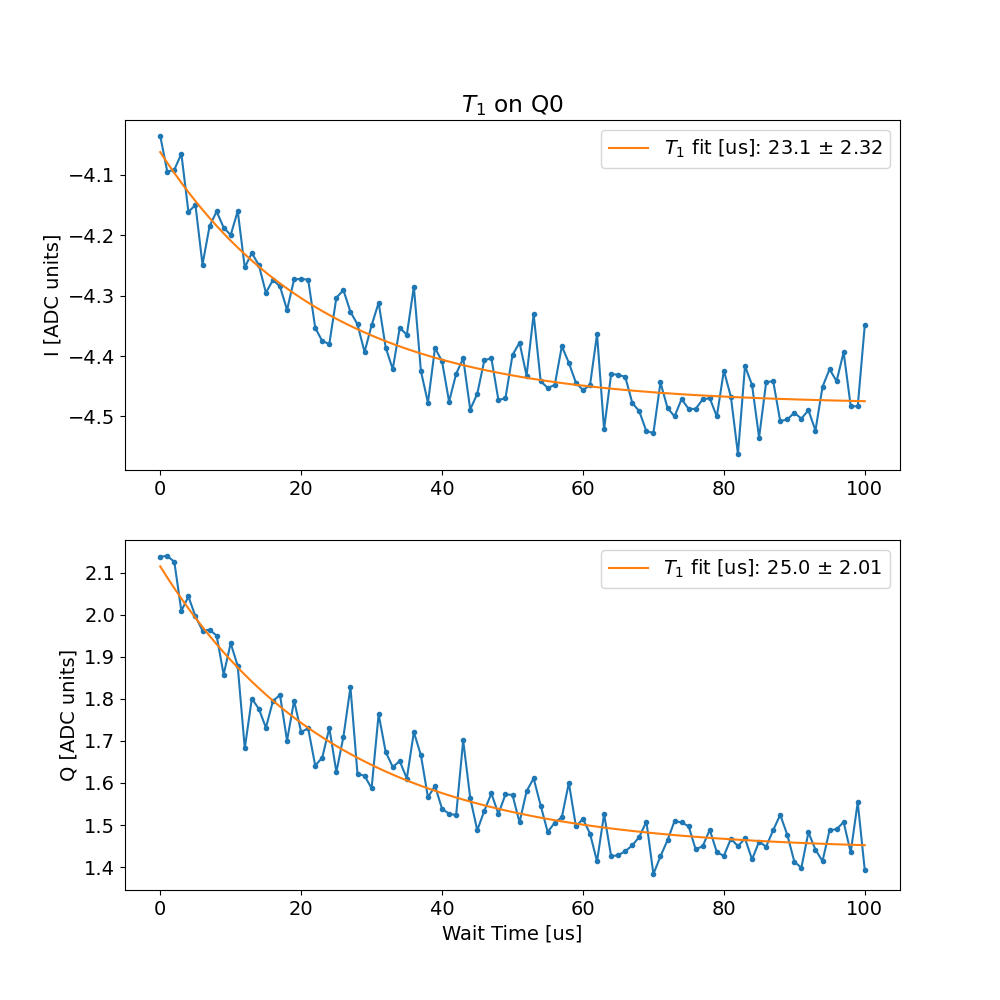

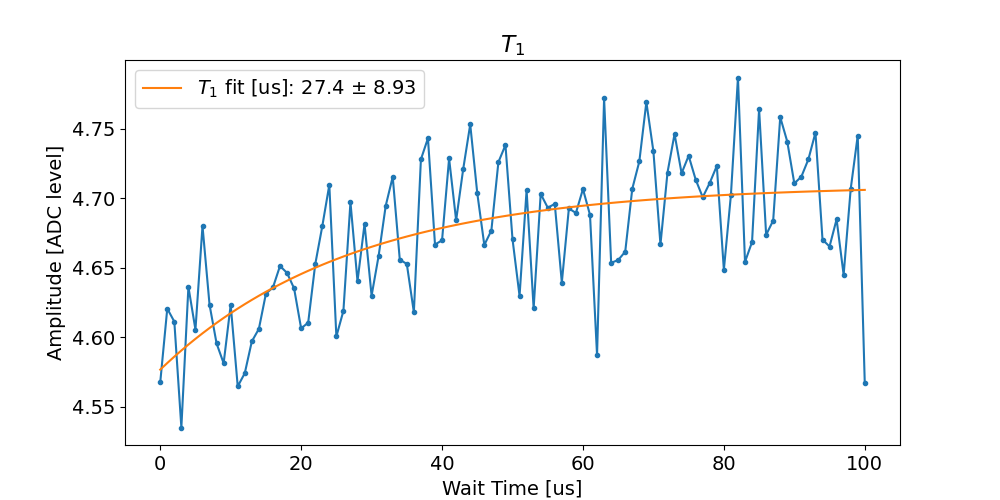

In [429]:
# TESTING
# t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit3.h5')
# data = t1.analyze(data=temp_data) #, fit_slice=(0, 50))
# t1.data = data
# t1.cfg = AttrDict(attrs['config'])
# print(t1.cfg.expt.reps, t1.cfg.expt.rounds, t1.cfg.expt.expts)

# t1.display(data=data, fit=True, fit_log=False)

# print('qubit', qubit_i)
t1.analyze()
t1.display(fit=True)

In [ ]:
t1.save_data()

Fit to quasiparticle excitations

In [ ]:
t1 = meas.T1Experiment(config_file=config_path,)
temp_data, attrs = prev_data(expt_path, '00003_t1_qubit2.h5')
data = t1.analyze(data=temp_data)
t1.data = data
t1.cfg = AttrDict(attrs['config'])


xpts_full = np.copy(t1.data['xpts'])
ypts_full = np.copy(t1.data['amps'])

ypts_full = (ypts_full - ypts_full[-1])/(ypts_full[0]-ypts_full[-1])

xpts_fit = np.copy(t1.data['xpts'][:-37])
ypts_fit = np.copy(ypts_full[:-37])

xpts_fit = xpts_fit[:-1]
ypts_fit = ypts_fit[:-1] # need to get rid of the 0 at the end of the sequence
print(ypts_fit)
ypts_logscale = np.log(ypts_fit)
print(ypts_logscale)
for i in range(len(xpts_fit)):
    if np.isnan(ypts_logscale[i]):
        ypts_logscale[i] = (ypts_logscale[i+1] + ypts_logscale[i-1])/2
print(ypts_logscale)


fitparams = [0.1, 20, 50]
fitparams = None
# p, pCov = meas.fitting.fitqpexp(xpts_fit, ypts_logscale, fitparams=fitparams)
p, pCov = meas.fitting.fitlogexp(xpts_fit, ypts_logscale, fitparams=fitparams)

plt.figure()
plt.yscale('log')
plt.plot(xpts_full, ypts_full,'o-')
plt.axhline(1/np.e, linestyle='--', color='k')

# captionStr = '$T_{1QP}$'+ f' fit [us]: {p[1]:.3} $\pm$ {np.sqrt(pCov[1][1]):.3}'
# captionStr += '\n$T_{1R}$'+ f' fit [us]: {p[2]:.3} $\pm$ {np.sqrt(pCov[2][2]):.3}'
# captionStr += '\n$n_{QP}$'+ f' fit [us]: {p[0]:.3} $\pm$ {np.sqrt(pCov[0][0]):.3}'
# fit_data = meas.fitting.qp_expfunc(xpts_fit, *p)

captionStr = '$T_{1}$'+ f' fit [us]: {p[0]:.3} $\pm$ {np.sqrt(pCov[0][0]):.3}'
fit_data = meas.fitting.logexpfunc(xpts_fit, *p)



fit_data = np.exp(fit_data)
plt.plot(xpts_fit, fit_data, label=captionStr)

plt.legend()
plt.xlabel("Wait Time [us]")
plt.ylabel("[ADC units]")
plt.show()

In [ ]:
t1.save_data()

## $T_2$ Ramsey Fringe Experiment

Measures the qubit $T_2$ Ramsey characteristic decay time by preparing the qubit in a superposition state with a  $\frac{\pi}{2}$ pulse (about X-axis) followed by a variable delay ($\tau$) before applying another $\frac{\pi}{2}$ pulse (about X-axis) with a phase advanced by $\Delta \phi = \omega * \tau$, where $\omega$ is the Ramsey frequency.

When qubit frequency is off by $\Delta$, oscillations will be observed at $\omega+\Delta$. Iterate on this experiment, adjusting the qubit frequency, until no oscillations are observed.

This exponential decay envelope can be fitted in post-processing to obtain the qubit $T_2$ Ramsey time.

In [ ]:
qubit_i =0

In [436]:
t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)

t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    expts=151,
    step=soc.cycles2us(50), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    ramsey_freq=0.5, # [MHz]
    # step=soc.cycles2us(120), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # ramsey_freq=0.100, # [MHz]
    reps=1000,
    rounds=10,
    qTest=qubit_i,
    qZZ=None, 
    # qubits=[2, 1], # qZZ, qTest
    checkZZ=False,
    checkEF=False,
    # cool_qubits=[1],
    # cool_idle=9.1, # us
)
print(t2r.cfg.expt.step)
# t2r.cfg.device.readout.gain = 0.05
# t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]
# t2r.cfg.device.qubit.pulses.pi_ge.gain = 4657
# t2r.cfg.device.qubit.pulses.pi_ge.sigma = 0.070

print(t2r.cfg)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

0.11625744047619048
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1], 'T1': [32, 20, 22, 25], 'T2ramsey': [20, 27, 12], 'chi': [0.45, 0.5, 0], 'kappa': [0.3, 0.2, 0.16, 0.18], 'frequency': [5342.94], 'gain': [0.01], 'readout_length': [10], 'relax_delay': [450]}, 'qubit': {'f_ge': [3366], 'f_ge_robust': [3515.44], 'f_ef': [4114.49], 'pulses': {'pi_ge': {'sigma': [0.2], 'gain': [19981], 'half_gain': [19981], 'half_correction_phase': [0], 'half_gain_pi_sigma': [927], 'type': 'gauss'}, 'pi_ef': {'sigma': [0.02], 'gain': [1280], 'half_gain': [1261], 'half_gain_pi_sigma': [673], 'type': 'gauss'}, 'pi_EgGf': {'gain': [32000], 'sigma': [0.586], 'type': 'flat_top'}, 'pi_EgGf_Q': {'gain': [0, 0, 19500, 15088], 'sigma': [0, 0, 0.4524085976144402, 0.3229981046477775], 'phase': [0, 0, 18.0, 24.0], 'half_sigma': [0, 0, 0.212, 0.172], 'half_phase': [0, 0, 18.0, 21.0], 'type': 'flat_top'}, 'pi_f0g1': {'gain': [32000, 32000, 32000, 32000], 'sigma': [0.536, 0.585, 1.54, 1.04], 'idle': [3, 

  0%|          | 0/10 [00:00<?, ?it/s]

Current pi pulse frequency: 3366
Fit frequency from amps [MHz]: 0.7255319998708392 +/- 0.0025814078137587357
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3365.774468000129
 	3364.774468000129
T2 Ramsey from fit amps [us]: 5.196707589285715 +/- 0.43964696362949657


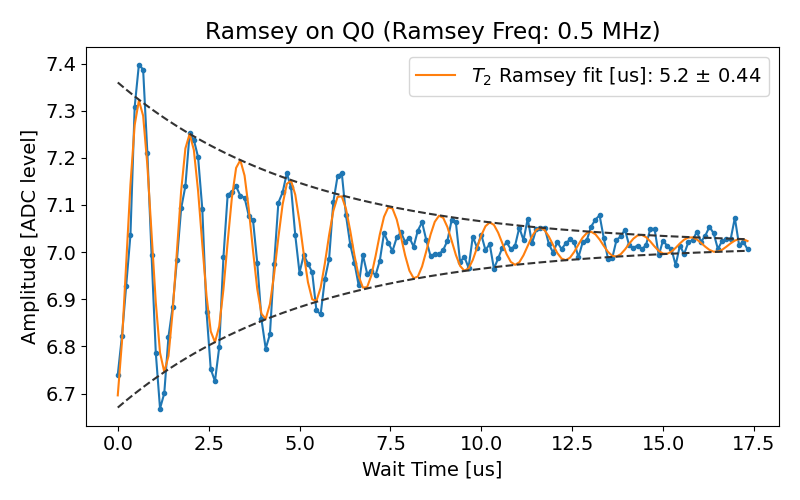

Current pi pulse frequency: 3366
Fit frequency from I [MHz]: 0.5588005436025215 +/- 0.006196590358747006
Suggested new pi pulse frequency from fit I [MHz]:
 	3365.9411994563975
 	3364.9411994563975
T2 Ramsey from fit I [us]: 5.196707589285715 +/- 1.1164560605043545
Fit frequency from Q [MHz]: 0.7241400490853439 +/- 0.0025357803690362743
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3365.7758599509148
 	3364.7758599509148
T2 Ramsey from fit Q [us]: 5.196707589285715 +/- 0.4327422716247503


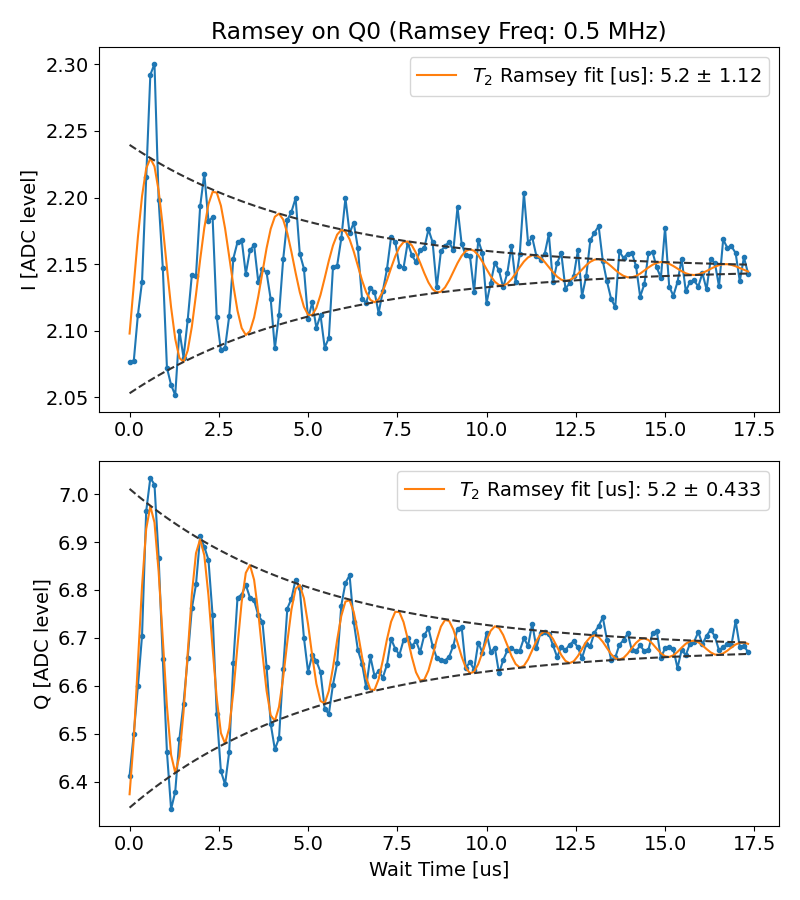

AttributeError: 'AttrDict' object has no attribute 'ZZs'

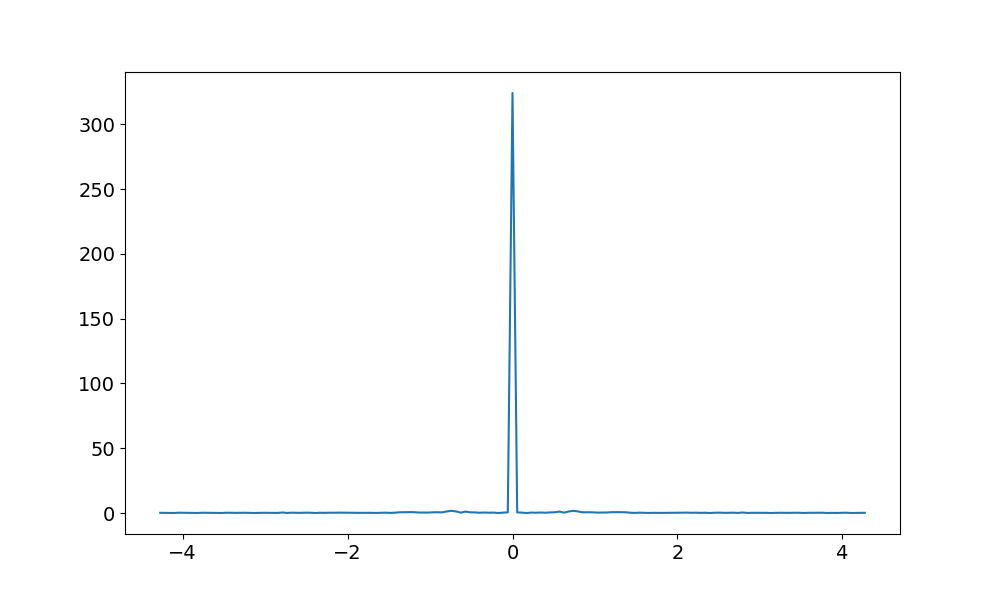

In [437]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r.cfg = AttrDict(attrs['config'])
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.analyze(fit=True, fit_num_sin=1)
t2r.display(fit=True, fit_num_sin=1)

plt.figure()
data = t2r.data
xpts = data['xpts']
fourier = np.fft.fftshift(np.abs(np.fft.fft(data['avgi'])))
freqs = np.fft.fftshift(np.fft.fftfreq(len(fourier), d=(xpts[1]-xpts[0])))
plt.plot(freqs, fourier)
ZZs = np.reshape(t2r.cfg.device.qubit.ZZs, (4, 4))
for i in range(4):
    plt.axvline(t2r.cfg.expt.ramsey_freq - ZZs[qubit_i, (qubit_i+i)%4], color='k', linewidth=0.5, linestyle='--')
plt.xlabel('Frequency [MHz]')
plt.xlim(-7, 7)
plt.ylim(0, 30000)
plt.title(f'Fourier Transform of Ramsey on Q{qubit_i} (Ramsey Freq: {t2r.cfg.expt.ramsey_freq})')
plt.show()

In [ ]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=2, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.save_data()

In [ ]:
temp = 1e3*-h*fge/(kB*np.log(efamp_nopulse/efamp_normal))

## $T_2$ Echo

Same idea as Ramsey, but add additional $\pi$ pulses in the middle of $\tau$  which prevent the qubit from decaying as quickly.

In [ ]:
soc.cycles2us(15)*1e3

In [228]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)

t2e.cfg.expt = dict(
    start=soc.cycles2us(30), # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(8), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=200,
    ramsey_freq=3.0, # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=False, # set either cp or cpmg to True
    cp=True, # set either cp or cpmg to True
    reps=800,
    rounds=1,
    qubit=qubit_i,
)

# t2e.cfg.device.readout.relax_delay = 3*t2e.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(t2e.cfg)

t2e.go(analyze=False, display=False, progress=True, save=False)

AttributeError: module 'experiments' has no attribute 'RamseyEchoExperiment'

In [ ]:
# # TESTING
# t2e = meas.RamseyEchoExperiment(config_file=config_path)
# t2e.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# data = t2e.analyze(data=temp_data, fit=True)
# t2e.display(data=data, fit=True)

print('qubit', qubit_i)
t2e.analyze(fit=True)
t2e.display(fit=True)

In [ ]:
t2e.save_data()

# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

Qubit ef frequency should be stored in <code>cfg.qubiti.f_ef</code>.

In [ ]:
qubit_i = 3

In [ ]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 25
npts = 150

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=int(50), # ef pulse gain
    pulse_type='gauss', # ef pulse type
    qubit=qubit_i,
)

# qEFspec.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]
# qEFspec.cfg.device.readout.gain = 0.75 # Wait time between experiments [us]
# qEFspec.cfg.device.readout.frequency[qubit_i] += 0.2 # Wait time between experiments [us]
print(qEFspec.cfg.expt)

qEFspec.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
config_path

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

qEFspec.analyze(fit=True, signs=[1, -1, 1])
qEFspec.display(fit=True, signs=[1, -1, 1])

In [ ]:
qEFspec.save_data()

### Pulse probe EF power sweep

In [ ]:
pulseprobeEFpowspec = meas.PulseProbeEFPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pulse_probe_ef_power_sweep_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 5
npts_f = 5

span_gain = 1000
npts_gain = 2

pulseprobeEFpowspec.cfg.expt = dict(
    start_f=pulseprobeEFpowspec.cfg.device.readout.frequency[qubit_i]-span_f/2, # Pulse frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=pulseprobeEFpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=1,
    step_gain=int(span_gain/npts_gain), # Gain step size
    expts_gain=npts_gain, # Number experiments stepping gain from start
    reps=10,
    rounds=10, # Number averages per point
    length=10, # ef const pulse length [us]
    qubit=qubit_i,
)
pulseprobeEFpowspec.cfg.device.readout.relax_delay = 2*pulseprobeEFpowspec.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(pulseprobeEFpowspec.cfg)

pulseprobeEFpowspec.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

pulseprobeEFpowspec.analyze(lowgain=None, highgain=None)
pulseprobeEFpowspec.display()

## Length EF Rabi

In [ ]:
lengthrabiEF = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabiEF_qubit{qubit_i}",
    config_file=config_path,
)

lengthrabiEF.cfg.expt = dict(
    start=soc.cycles2us(1), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0,
    expts=101,
    reps=1000,
    gain=yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]//3, # qubit gain [DAC units],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    pulse_ge=True,
    # cool_qubits=[1],
    # cool_idle=9.1, # us
    qubits=[qubit_i],
)
# lengthrabiEF.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
lengthrabiEF.save_data()

In [ ]:
# # TESTING
# # lengthrabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabiEF.data = temp_data

lengthrabiEF.analyze(fit=True, fit_func='sin')

# lengthrabiEF_fit, lengthrabiEF_fit_err = meas.fitting.get_best_fit(lengthrabiEF.data) #, fitfunc=fitter.decaysin)

lengthrabiEF.display(fit=True, fit_func='sin')

fit_axis = 'amps'

lengthrabiEF_data = lengthrabiEF.data[fit_axis]
p = lengthrabiEF.data[f'fit_{fit_axis}']
# efamp_normal = p[0]
# efamp_nopulse = p[0]
print(p[0])

# p = lengthrabiEF_fit
# if p[2] > 180: p[2] = p[2] - 360
# elif p[2] < -180: p[2] = p[2] + 360
# if p[2] < 0: pi_lenEF = (1/2 - p[2]/180)/2/p[1]
# else: pi_lenEF = (3/2 - p[2]/180)/2/p[1]
# pi_lenEF = np.max((0.9*pi_lenEF, 0.015)) # since we run the length rabi at a < max gain

# lengthrabiEF_decay = p[3]

# print(f'Use sigma {pi_lenEF} for amplitude rabi EF')

Sweep length rabi over wait times

In [ ]:
wait_times = np.linspace(1, 10, 21)
saved_files = []
print(wait_times)
data_amps = []
data_avgi = []
data_avgq = []

for wait in wait_times:
    print(wait)
    lengthrabiEF = meas.LengthRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"length_rabiEF_qubit{qubit_i}",
        config_file=config_path,
    )

    lengthrabiEF.cfg.expt = dict(
        start=soc.cycles2us(1), # pulse length (sigma) [us]
        step=soc.cycles2us(1), # [us]
        # step=0,
        expts=101,
        reps=10000,
        gain=yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]//3, # qubit gain [DAC units],
        pulse_type='gauss',
        checkZZ=False,
        checkEF=True, 
        pulse_ge=False,
        cool_qubits=[1],
        cool_idle=wait, # us
        qubits=[qubit_i],
    )
    # lengthrabiEF.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

    import Pyro4.util
    try:
        lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
    saved_files.append(lengthrabiEF.save_data())

    data_amps.append(lengthrabiEF.data['amps'])
    data_avgi.append(lengthrabiEF.data['avgi'])
    data_avgq.append(lengthrabiEF.data['avgq'])

In [ ]:
plot_xpts = lengthrabiEF.data['xpts']
plot_ypts = wait_times
data = np.copy(data_amps)

amplitudes = []
maxes = []
mins = []
for length_rabi in data:
    amplitudes.append(max(length_rabi) - min(length_rabi))
    maxes.append(max(length_rabi))
    mins.append(min(length_rabi))
maxes = np.array(maxes) - min(mins)
mins = np.array(mins) - min(mins)

plt.figure()
plt.pcolormesh(plot_xpts, plot_ypts, data, cmap='viridis', shading='auto')
plt.colorbar()
plt.xlabel('Pulse Length [ns]')
plt.ylabel('Wait Time [us]')
plt.show()

plt.figure()
# plt.plot(wait_times, amplitudes, label='amplitude')
# plt.plot(wait_times, maxes, '--', label='max')
# plt.plot(wait_times, mins, '--', label='min')
for i in range(len(wait_times)//2):
    plt.plot(plot_xpts, data[i]-min(data), linewidth=1, label=f'{wait_times[i]:.3}')
plt.xlabel('Pulse Length [ns]')
plt.ylabel('Amplitude max-min [ADC units]')
plt.ylim(-0.1, 1.1*(max(data)-min(data)))
plt.legend()
plt.show()

plt.figure()
# plt.plot(wait_times, amplitudes, label='amplitude')
# plt.plot(wait_times, maxes, '--', label='max')
# plt.plot(wait_times, mins, '--', label='min')
for i in range(len(wait_times)//2, len(wait_times)):
    plt.plot(plot_xpts, data[i]-min(data), linewidth=1, label=f'{wait_times[i]:.3}')
plt.xlabel('Pulse Length [ns]')
plt.ylabel('Amplitude max-min [ADC units]')
plt.legend()
#     plt.plot(plot_xpts, data[i] - min(data))
plt.ylim(-0.1, 1.1*(max(data)-min(data)))
plt.show()

for i in range(len(wait_times)):
    plt.figure(figsize=(5, 2))
    plt.plot(plot_xpts, data[i] - min(data), label=f'{wait_times[i]}')
    plt.ylim(-0.1, 1.1*(max(data)-min(data)))
    plt.xlabel('Pulse Length [ns]', fontsize=10)
    plt.ylabel('max-min [ADC units]', fontsize=10)
    plt.legend()
    plt.show()

## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [ ]:
qubit_i = 0

In [ ]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

# span = 6000
npts = 10

amprabiEF.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts+1,
    # step=amprabiEF.cfg.device.qubit.pulses.pi_ef.gain[qubit_i],
    # expts=2,
    reps=100,
    rounds=10,
    pulse_type='gauss',
    # sigma_test=0.013, # gaussian sigma for pulse length - default from cfg [us]
    checkZZ=False,
    # checkEF=True, 
    # pulse_ge=True,
    # cool_qubits=[1],
    # cool_idle=9.1, # us
    # check heating from swap
    checkEF=True, 
    pulse_ge=True,
    apply_EgGf=False,
    # qubits_EgGf=[2, 1],
    # qDrive=2,


    qubits=[qubit_i],
)

# change the readout gain 



print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# amprabiEF = meas.AmplitudeRabiEFExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# data = amprabiEF.analyze(data=temp_data, fit=True)
# amprabiEF.display(data=data, fit=True)

# xdata = amprabiEF.data['xpts']
# fitparams=[None]*4
# fitparams[1]=2/xdata[-1]

# amprabiEF.analyze(fit=True, fitparams=fitparams)


# fit_axis = 'amps'
# # fit_axis = 'avgq'

# amprabiEF_data = amprabiEF.data[fit_axis]
# p = amprabiEF.data[f'fit_{fit_axis}']
# efamp = p[0]
# print('fit amplitude', efamp)
# efamp = max(amprabiEF.data[fit_axis]) - min(amprabiEF.data[fit_axis])
# print('max-min', efamp)


amprabiEF.display(fit=False)

In [ ]:
amprabiEF.save_data()

### Qubit temperature
Run amplitude rabi EF twice, once with and once without pulse_ge. Input the amplitude of the rabi oscillation (printed in the cell below) for each of these cases to calculate qubit temperature from the ratio.

In [ ]:
# NATRUAL CONSTANTS
h = 6.62607015e-34
fge = 1e6*(amprabiEF.cfg.device.qubit.f_ge[qubit_i] + amprabiEF.cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i])
kB = 1.380649e-23
################

fit_axis = 'amps'
# fit_axis = 'avgq'

efamp_normal = 372 
efamp_nopulse = 7.05

print('Qubit temp [mK]:', -1e3*h*fge/(kB*np.log(efamp_nopulse/efamp_normal)))

pop_e = efamp_nopulse/efamp_normal
print('Population in e:', pop_e)


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [ ]:
1/(soc.cycles2us(1)*151)

In [ ]:
t2EFr = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    expts=150,
    step=soc.cycles2us(150), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    ramsey_freq=0.100, # [MHz]
    # step=soc.cycles2us(40), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # ramsey_freq=0.300, # [MHz]
    checkZZ=False,
    checkEF=True,
    reps=100,
    rounds=30,
    qubits=[qubit_i],
)
t2EFr.cfg.device.readout.frequency = t2EFr.cfg.device.readout.frequency_ef

print(t2EFr.cfg)

t2EFr.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# t2EFr = meas.RamseyEFExperiment(config_file=config_path)
# t2EFr.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# temp_data = temp_data[0]
# data = t2EFr.analyze(data=temp_data, fit=True)
# t2EFr.display(data=data, fit=True)

t2EFr.analyze(fit=True)
t2EFr.display(fit=True)

In [ ]:
t2EFr.save_data()